<a href="https://colab.research.google.com/github/UCREL/Session1_Visualisation_and_Summarisation/blob/main/NoteBooks/3_Text_Summariser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tutorial: Building a Text Summarizer
![Comparison Diagram](https://raw.githubusercontent.com/Nouran-Khallaf/NLP_Visualisation/main/static/images/Extractive-vs-Abstractive-Summarization.png)
*Diagram 1: Comparative Analysis of Summarization Techniques*


### Introduction
This notebook demonstrates how to build a text summarizer using  Multi-document Summaries Corpora (2011 and 2013) dataset.
The dataset is derived from publicly available WikiNews (http://www.wikinews.org/) English texts. The source texts were under CC Attribution Licence V2.5 (http://creativecommons.org/licenses/by/2.5/). Texts in other languages have been translated by native speakers of each language.
Languages included:
- Arabic
- Czech
- English
- French
- Greek
- Hebrew
- Hindi
- Chinese (2013)
- Romanian (2013)
- Spanish (2013)

For more information, please visit [Multi-document Summaries Corpora](https://www.lancaster.ac.uk/staff/elhaj/corpora.html).



**Extractive Summarization**:
Extractive summarization involves selecting key sentences or phrases from the original text and concatenating them to create a summary. The goal is to extract the most important information while maintaining the original context. This method does not generate new sentences but rather identifies and extracts the most relevant parts of the text.




**Abstractive Summarization**:
Abstractive summarization, on the other hand, involves generating new sentences that convey the most important information from the original text. This method goes beyond simply extracting key phrases and instead uses techniques like natural language generation to create a coherent and concise summary that may include paraphrasing and restructuring of information.

![Comparison Diagram](https://raw.githubusercontent.com/Nouran-Khallaf/NLP_Visualisation/main/static/images/extractive.webp)![Comparison Diagram](https://raw.githubusercontent.com/Nouran-Khallaf/NLP_Visualisation/main/static/images/abstractive.png)
*Diagram 2: Analysis of Extractive Summarization *
*Diagram 3: Analysis of Abstractive Summarization *

---


In [ ]:
!pip install gdown
!pip install plotly
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install tabulate
!pip install summa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 49.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54386 sha256=69696e45dcf685c54a5c9ab023a2f3fe318a58938360b92be0d85761a5fb9c90
  Stored in directory: /root/.cache/pip/wheels/4a/ca/c5/4958614cfba88ed6ceb7cb5a849f9f89f9ac49971616bc919f
Successfully built summa


## Step 2: Load and Prepare Data
We will load the dataset and clean it. For demonstration purposes.

In [ ]:
import gdown
url = 'https://drive.google.com/uc?id=1GSRJgJaRzb1OauKtHdwNoF4UnkKAt9cK'
output = 'Multilingual-Dataset.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1GSRJgJaRzb1OauKtHdwNoF4UnkKAt9cK
To: /content/Multilingual-Dataset.zip
100%|██████████| 1.28M/1.28M [00:00<00:00, 90.3MB/s]


'Multilingual-Dataset.zip'

In [ ]:

import zipfile
import os

if zipfile.is_zipfile(output):
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall('/content/')
    print("Files extracted:")
    print(os.listdir('/content/'))
else:
    print("Downloaded file is not a zip file.")

Files extracted:
['.config', 'Multilingual-Dataset.zip', 'SourceTexts', '__MACOSX', 'sample_data']


---


## **Data** **Prepration**
we need to organize the text files in the `SourceTexts` directory into subdirectories based on language identifiers extracted from the filenames. It dynamically identifies unique language codes, creates corresponding language-specific folders, and moves each file to its appropriate folder, thereby streamlining file management and access based on language.

- Arabic
- Czech
- English
- French
- Greek
- Hebrew
- Hindi

In [ ]:
import os
import shutil

# Define the source directory
source_dir = 'SourceTexts'

# List all files in the source directory
files = os.listdir(source_dir)

# Create a set to store unique language identifiers
languages = set()

# Identify unique languages from filenames
for file in files:
    language = file.split('.')[1].lower()  # Normalize to lowercase
    languages.add(language)

# Create folders for each language and move corresponding files
for language in languages:
    # Create the language folder if it doesn't exist
    language_dir = os.path.join(source_dir, language)
    os.makedirs(language_dir, exist_ok=True)

    # Move files into the language folder
    for file in files:
        if file.split('.')[1].lower() == language:  # Normalize to lowercase
            shutil.move(os.path.join(source_dir, file), os.path.join(language_dir, file))

print("Files have been organized into folders.")


Files have been organized into folders.


Here we combine the content of text files from the `SourceTexts` directory into a single Pandas DataFrame, with each file's content stored as a row in the DataFrame. It then saves the DataFrame to a CSV file.

1. **Import Required Modules**:
   - The script imports the `os` module for directory and file operations and the `pandas` module for creating and manipulating the DataFrame.

In [ ]:
import os
import pandas as pd


2. **Define the Function to Combine Files**:
   - A function named `combine_files_to_dataframe` is defined. This function takes a directory path as input and returns a DataFrame containing the file names and their contents.
- **Initialize an Empty List**: An empty list named `data` is created to store the file names and their contents.
- **Loop Through Files**: The function loops through all files in the specified directory using `os.listdir()`.
- **Construct Full File Path**: For each file, the full path is constructed using `os.path.join()`.
- **Check if it’s a File**: The script ensures the path is a file using `os.path.isfile()`.
- **Read File Content**: If it’s a file, the script reads its content and appends a dictionary containing the file name (`Title`) and its content (`Content`) to the `data` list.
- **Create a DataFrame**: Finally, a Pandas DataFrame is created from the `data` list and returned.

In [ ]:
def combine_files_to_dataframe(directory_path):
       # Initialize an empty list to store the data
       data = []

       # Loop through all files in the directory
       for file_name in os.listdir(directory_path):
           # Construct full file path
           file_path = os.path.join(directory_path, file_name)

           # Ensure it's a file
           if os.path.isfile(file_path):
               # Read the content of each file
               with open(file_path, 'r') as file:
                   content = file.read()
                   # Append the file name and content to the data list
                   data.append({'Title': file_name, 'Content': content.strip()})

       # Create a DataFrame from the data list
       df = pd.DataFrame(data)
       return df


3. **Specify the Directory Path**:
   - The directory containing the files is specified. In this example, the directory path is `/content/SourceTexts/english`.

In [ ]:
directory_path = '/content/SourceTexts/english' ## here you can change the language

4. **Combine Files into a DataFrame**:
   - The `combine_files_to_dataframe` function is called with the specified directory path, and the resulting DataFrame is stored in the variable `df`.

In [ ]:
df = combine_files_to_dataframe(directory_path)

5. **Display the DataFrame**:
   - The DataFrame is printed to the console to display the combined content of the files.

In [ ]:
print(df)

            Title                                            Content
0   M0014.english  London bomb survivors launch campaign for publ...
1   M0043.english  Nobel prize winner Al Gore urges US and China ...
2   M0082.english  Wreckage of plane thought to be missing Air Fr...
3   M0046.english  Climate Conference in Bali concluded; opinions...
4   M0099.english  Protests surround London Olympic torch relay\n...
..            ...                                                ...
95  M0087.english  Aviation experts suggest Air France Flight 447...
96  M0050.english  8.8 magnitude earthquake hits Chile; tsunami w...
97  M0062.english  Details emerge in Haiti earthquake; thousands ...
98  M0091.english  2008 Olympic Games officially open\n\nFriday, ...
99  M0001.english  Aid pledges rise; Japan promises 500,000,000 U...

[100 rows x 2 columns]




6. **Save the DataFrame to a CSV File**:
   - The DataFrame is saved to a CSV file named `combined_files.csv` without the index using the `to_csv` method.

In [ ]:
df.to_csv('combined_files.csv', index=False)


---

> The following code cell is designed to perform the combined operations described above. Let's execute it to see the results.
---

In [33]:
import os
import pandas as pd

def combine_files_to_dataframe(directory_path):
    # Initialize an empty list to store the data
    data = []

    # Loop through all files in the directory
    for file_name in os.listdir(directory_path):
        # Construct full file path
        file_path = os.path.join(directory_path, file_name)

        # Ensure it's a file
        if os.path.isfile(file_path):
            # Read the content of each file
            with open(file_path, 'r') as file:
                content = file.read()
                # Append the file name and content to the data list
                data.append({'Title': file_name, 'Content': content.strip()})

    # Create a DataFrame from the data list
    df = pd.DataFrame(data)
    return df

# Specify the directory containing the files
directory_path = '/content/SourceTexts/english'

# Combine the files into a DataFrame
df = combine_files_to_dataframe(directory_path)

# Display the DataFrame
print(df)

# save the DataFrame to a CSV file
df.to_csv('combined_files.csv', index=False)

            Title                                            Content
0   M0009.english  Romanian artists auction off their works for t...
1   M0005.english  Saskatchewan town asks for return of "accident...
2   M0045.english  Climate Negotiations soon to conclude in Bali;...
3   M0070.english  Graner found guilty of mistreatment at Abu Ghr...
4   M0028.english  UK naval crew describe their capture and deten...
..            ...                                                ...
95  M0016.english  Five found guilty of UK bomb plot\n\nTuesday, ...
96  M0074.english  New photos of Abu Ghraib prison abuse\n\nWedne...
97  M0010.english  London bombing: Police search houses in Leeds\...
98  M0069.english  UN reports 222,570 dead in Haiti earthquake\n\...
99  M0083.english  Aircraft wreckage in Atlantic confirmed to be ...

[100 rows x 2 columns]


## Step 3: Data Cleaning

Enhances the readability and usability of text data by:
1. Removing HTML tags using the `BeautifulSoup` library.
2. Cleaning the text with regular expressions to replace multiple spaces, remove standalone numbers, and trim whitespace.
3. Loading the original text data from a CSV file into a DataFrame.
4. Applying the text cleaning process to the 'Content' column and storing the cleaned text in a new column named 'clean_content'.

In [ ]:
import pandas as pd
import re
from bs4 import BeautifulSoup

2. **Define a Function to Clean HTML**:
   - A function named `clean_html` is defined to remove HTML tags from a string. It uses `BeautifulSoup` to parse the HTML and extract the text content.
- **Parameter**: `raw_html` - The raw HTML string to be cleaned.
- **Processing**: `BeautifulSoup` parses the HTML and the `get_text()` method extracts the text content.
- **Return**: The cleaned text without HTML tags.

In [ ]:
def clean_html(raw_html):
       """Remove HTML tags from a string"""
       soup = BeautifulSoup(raw_html, "html.parser")
       return soup.get_text()

3. **Define a Function to Clean Text**:
  - A function named `clean_text` is defined to clean the text by removing unwanted patterns and extra spaces. It first removes HTML tags using the `clean_html` function and then applies various regular expressions to clean the text further.
- **Parameter**: `text` - The text string to be cleaned.
- **Processing**:
     - `clean_html(text)`: Removes HTML tags.
     - `re.sub(r'\s+', ' ', text)`: Replaces multiple spaces and newlines with a single space.
     - `re.sub(r'\b\d+\b', '', text)`: Removes standalone numbers (optional, based on specific needs).
     - `text.strip()`: Removes leading and trailing spaces.
- **Return**: The cleaned text.

In [ ]:
def clean_text(text):
       """Remove unwanted text patterns and clean the text"""
       text = clean_html(text)
       text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces/newlines with a single space
       text = re.sub(r'\b\d+\b', '', text)  # Remove standalone numbers if needed
       text = text.strip()  # Remove leading/trailing spaces
       return text

4. **Load the DataFrame**:
   - The script loads a DataFrame from a CSV file named `combined_files.csv` using the `pandas` library.


In [ ]:
df = pd.read_csv('combined_files.csv')

5. **Apply Preprocessing to the 'Content' Column**:
   - The script applies the `clean_text` function to each entry in the 'Content' column of the DataFrame, creating a new column 'clean_content' with the cleaned text.
- **Processing**: The `apply` method is used to apply the `clean_text` function to each row in the 'Content' column.
- **Result**: A new column 'clean_content' is added to the DataFrame containing the cleaned text.

In [ ]:
df['clean_content'] = df['Content'].apply(clean_text)


---

> The following code cell is designed to perform the combined operations described above. Let's execute it to see the results.
---

In [35]:
import pandas as pd
import re
from bs4 import BeautifulSoup

def clean_html(raw_html):
    """Remove HTML tags from a string"""
    soup = BeautifulSoup(raw_html, "html.parser")
    return soup.get_text()

def clean_text(text):
    """Remove unwanted text patterns and clean the text"""
    text = clean_html(text)
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces/newlines with a single space
    text = re.sub(r'\b\d+\b', '', text)  # Remove standalone numbers if needed
    text = text.strip()  # Remove leading/trailing spaces
    return text


# Load your DataFrame
df = pd.read_csv('combined_files.csv')

# Apply preprocessing to the 'Content' column
df['clean_content'] = df['Content'].apply(clean_text)

#Extractive Summary

## 1- Extractive Summarisation using TF-IDF
extractive summarization using the TF-IDF (Term Frequency-Inverse Document Frequency) method:

1. **Calculate TF-IDF scores for each term in the document**.
2. **Rank sentences based on the sum of TF-IDF scores of their terms**.
3. **Select the top N sentences with the highest scores as the summary**.

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
# Function to generate extractive summary using TF-IDF
def extractive_summary(text, top_n=3):
    sentences = text.split('.')
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(sentences)
    sentence_scores = np.sum(X.toarray(), axis=1)
    top_sentence_indices = sentence_scores.argsort()[-top_n:][::-1]
    summary = '. '.join([sentences[i].strip() for i in top_sentence_indices if sentences[i].strip()]) + '.'
    return summary

# Apply the summarization function to each content
df['Tfidf_Summary'] = df['clean_content'].apply(extractive_summary)

# Display the DataFrame with summaries
print(df[['Title', 'clean_content','Tfidf_Summary']])

            Title                                      clean_content  \
0   M0009.english  Romanian artists auction off their works for t...   
1   M0005.english  Saskatchewan town asks for return of "accident...   
2   M0045.english  Climate Negotiations soon to conclude in Bali;...   
3   M0070.english  Graner found guilty of mistreatment at Abu Ghr...   
4   M0028.english  UK naval crew describe their capture and deten...   
..            ...                                                ...   
95  M0016.english  Five found guilty of UK bomb plot Tuesday, May...   
96  M0074.english  New photos of Abu Ghraib prison abuse Wednesda...   
97  M0010.english  London bombing: Police search houses in Leeds ...   
98  M0069.english  UN reports , dead in Haiti earthquake Thursday...   
99  M0083.english  Aircraft wreckage in Atlantic confirmed to be ...   

                                        Tfidf_Summary  
0   In an event titled Romanian Artists in Support...  
1   Saskatchewan town a

### 2. Extractive Summarisation using Sumy and Summa
Implement a simple text summarizer based on sentence extraction.

In [37]:
!pip install sumy
!pip install nltk
!pip install summa
!pip install seaborn mglearn
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import nltk
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from summa import summarizer
nltk.download('punkt')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 18.1 MB/s eta 0:00:00
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21693 sha256=2854abd5f0b01130fa54a03156611632f5e341ef90d4b39c20a816e3c54d8786
  Stored in directory: /root/.cache/pip/wheels/64/22/90/b84fcc30e16598db20a0d41340616dbf9b1e82bbcc627b0b33
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=9f8f3f5ab92dee6e540e7bc0583431caa91dc2a2967923109d512ec432dd3c9f
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built breadability docopt


In [39]:
def summarize_text(text, sentences_count=2):
    """Summarize the text using LSA summarizer"""
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = LsaSummarizer()
    summary = summarizer(parser.document, sentences_count)
    return ' '.join([str(sentence) for sentence in summary])

# Apply summarization to the 'clean_content' column
df['sumy_summary'] = df['clean_content'].apply(lambda x: summarize_text(x, sentences_count=2))

# Display the DataFrame with summaries
print(df[['Title', 'sumy_summary']])

# Save the DataFrame with summaries to a CSV file
df.to_csv('summarized_files.csv', index=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


            Title                                       sumy_summary
0   M0009.english  Romanian artists auction off their works for t...
1   M0005.english  Saskatchewan town asks for return of "accident...
2   M0045.english  Climate Negotiations soon to conclude in Bali;...
3   M0070.english  Graner, , was described as the ringleader duri...
4   M0028.english  UK naval crew describe their capture and deten...
..            ...                                                ...
95  M0016.english  It has now been revealed that the guilty had p...
96  M0074.english  Executive producer Mike Carey said Dateline ha...
97  M0010.english  Further properties were searched in Dewsbury, ...
98  M0069.english  UN reports , dead in Haiti earthquake Thursday...
99  M0083.english  An airplane seat and life vest were found floa...

[100 rows x 2 columns]


In [43]:
def summa_summarize(text, ratio=0.2):
    """Summarize text using the summa library"""
    summary = summarizer.summarize(text, ratio=ratio, language='english')
    return summary

In [44]:
# Apply summarization to the 'clean_content' column using summa
df['summa_summary'] = df['clean_content'].apply(lambda x: summa_summarize(x, ratio=0.2))
# Save the cleaned and summarized data to a CSV file if needed
df.to_csv('cleaned_and_summarized_contents.csv', index=False)


### 6. Save Summarized Data
Save the summarized data to a new CSV file.

In [75]:
output_file = 'summarized_data.csv'
df.to_csv(output_file, index=False)
print(f"Summarized data saved to {output_file}")

Summarized data saved to summarized_data.csv


### 7. Visualise Results
Visualise the length of original texts vs. summaries.

In [115]:
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

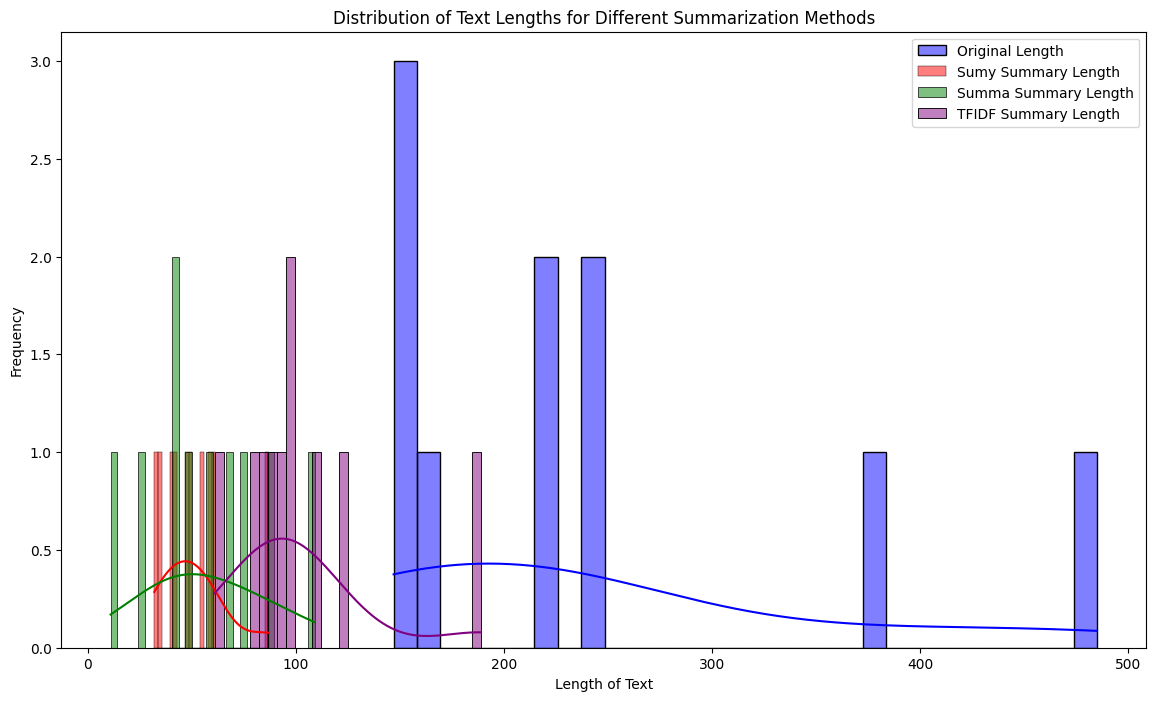

In [116]:
# Load the data
df = pd.read_csv('summarized_data.csv')

# Calculating the lengths of the original and summarized texts
df['original_length'] = df['clean_content'].apply(lambda x: len(x.split()))
df['summary_sumy_length'] = df['summary_sumy'].apply(lambda x: len(x.split()))
df['summary_summa_length'] = df['summary_summa'].apply(lambda x: len(x.split()))
df['summary_tfidf_length'] = df['summary_tfidf'].apply(lambda x: len(x.split()))
#df['summary_transformer_length'] = df['summary_transformer'].apply(lambda x: len(x.split()))  # Assuming transformer summary column exists

# Plotting the distribution of text lengths
plt.figure(figsize=(14, 8))
sns.histplot(df['original_length'], kde=True, color='blue', label='Original Length', bins=30)
sns.histplot(df['summary_sumy_length'], kde=True, color='red', label='Sumy Summary Length', bins=30)
sns.histplot(df['summary_summa_length'], kde=True, color='green', label='Summa Summary Length', bins=30)
sns.histplot(df['summary_tfidf_length'], kde=True, color='purple', label='TFIDF Summary Length', bins=30)
#sns.histplot(df['summary_transformer_length'], kde=True, color='orange', label='Transformer Summary Length', bins=30)
plt.legend()
plt.title('Distribution of Text Lengths for Different Summarization Methods')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.show()


### 1. Box Plots
**Box Plots**:
   Box plots can show the distribution, median, and outliers for each summarization method in a more compact way.

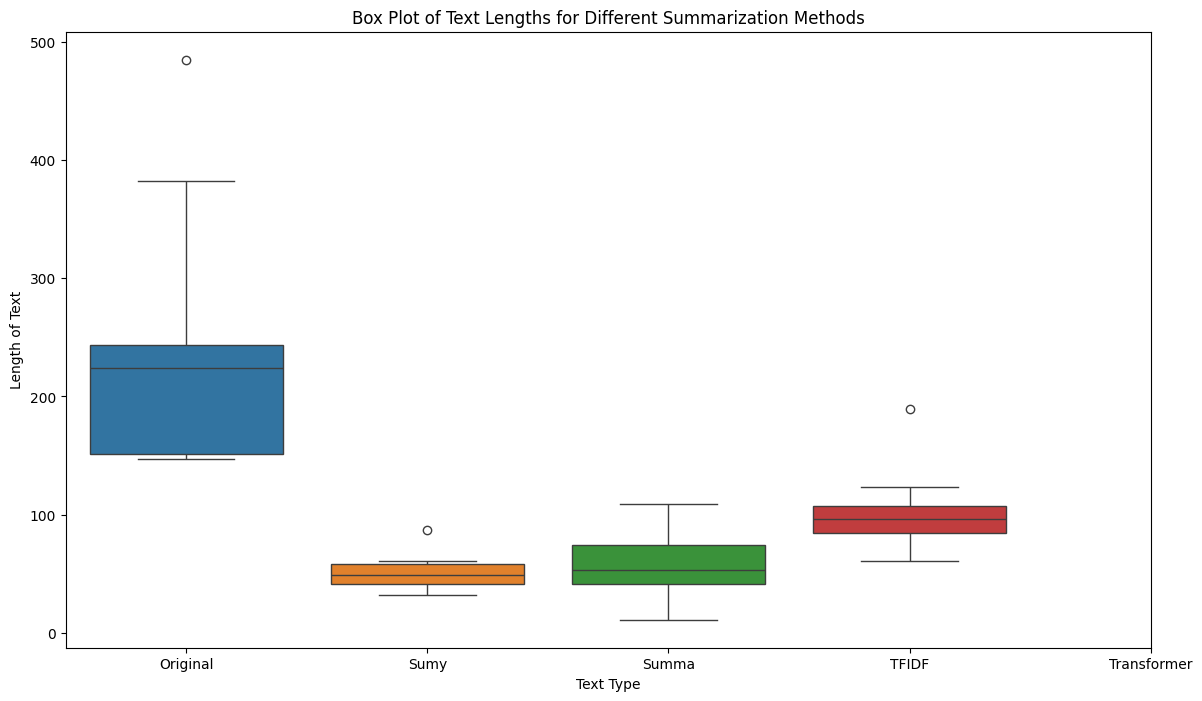

In [117]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=df[['original_length', 'summary_sumy_length', 'summary_summa_length', 'summary_tfidf_length']])
plt.title('Box Plot of Text Lengths for Different Summarization Methods')
plt.xlabel('Text Type')
plt.ylabel('Length of Text')
plt.xticks([0, 1, 2, 3, 4], ['Original', 'Sumy', 'Summa', 'TFIDF', 'Transformer'])
plt.show()


### 2. Bar Plots of Mean Lengths
**Bar Plots of Mean Lengths**:
   A bar plot can provide a quick comparison of the average lengths of the original texts and their summaries.


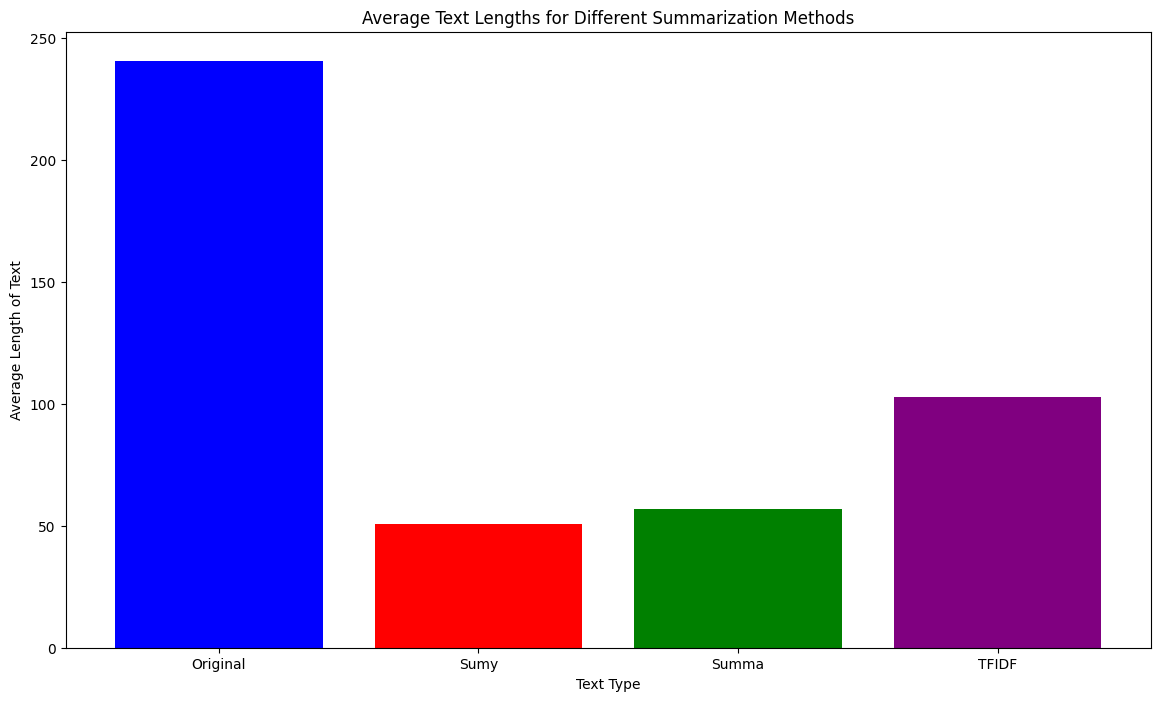

In [118]:
mean_lengths = {
    'Original': df['original_length'].mean(),
    'Sumy': df['summary_sumy_length'].mean(),
    'Summa': df['summary_summa_length'].mean(),
    'TFIDF': df['summary_tfidf_length'].mean()
}

plt.figure(figsize=(14, 8))
plt.bar(mean_lengths.keys(), mean_lengths.values(), color=['blue', 'red', 'green', 'purple', 'orange'])
plt.title('Average Text Lengths for Different Summarization Methods')
plt.xlabel('Text Type')
plt.ylabel('Average Length of Text')
plt.show()



###3. Pairwise Comparison with Scatter Plots
**Pairwise Comparison with Scatter Plots**:
   Scatter plots can help visualize the relationship between the lengths of original texts and their summaries for each method.


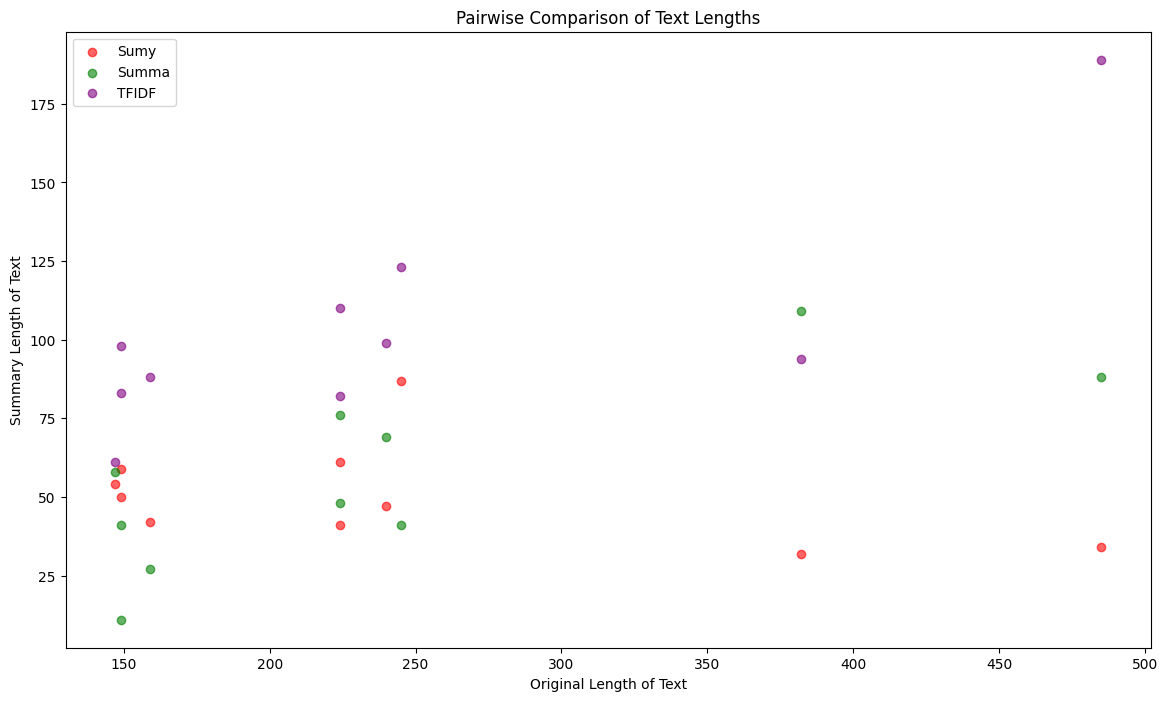

In [119]:
plt.figure(figsize=(14, 8))
plt.scatter(df['original_length'], df['summary_sumy_length'], color='red', label='Sumy', alpha=0.6)
plt.scatter(df['original_length'], df['summary_summa_length'], color='green', label='Summa', alpha=0.6)
plt.scatter(df['original_length'], df['summary_tfidf_length'], color='purple', label='TFIDF', alpha=0.6)
plt.title('Pairwise Comparison of Text Lengths')
plt.xlabel('Original Length of Text')
plt.ylabel('Summary Length of Text')
plt.legend()
plt.show()


### 4. Distribution Plot with KDE
**Distribution Plot with KDE**:
   A more detailed distribution plot using Kernel Density Estimation (KDE) to show the continuous distribution of text lengths.

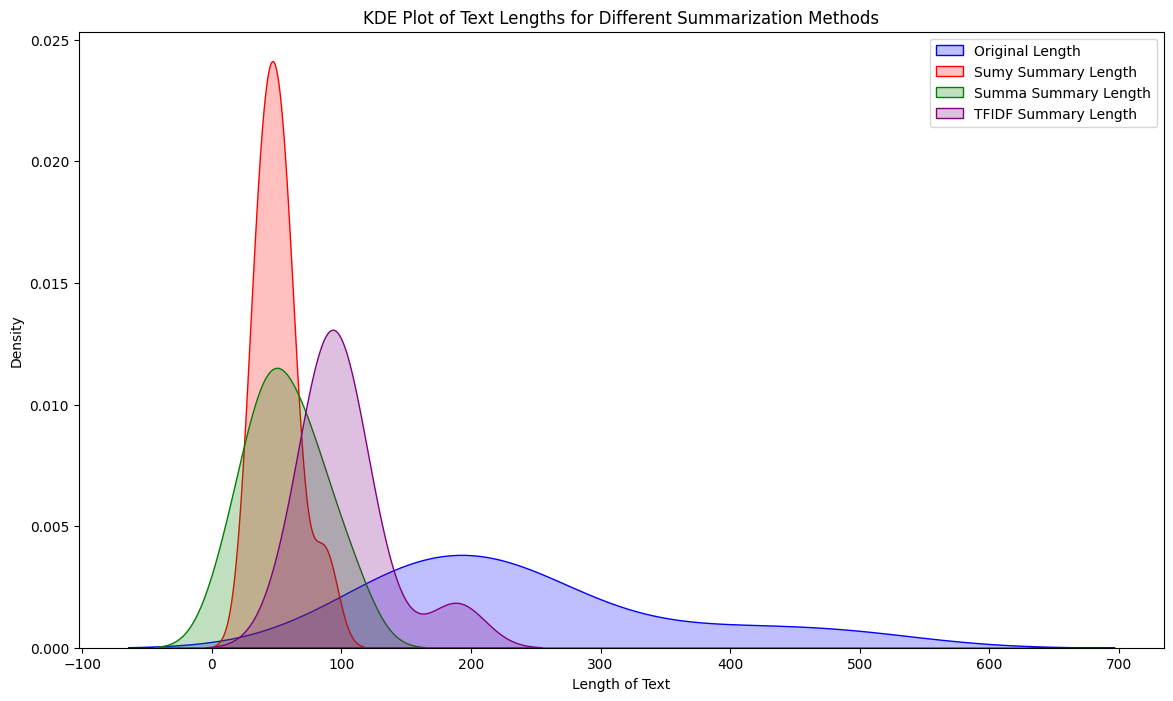

In [120]:
plt.figure(figsize=(14, 8))
sns.kdeplot(df['original_length'], color='blue', label='Original Length', fill=True)
sns.kdeplot(df['summary_sumy_length'], color='red', label='Sumy Summary Length', fill=True)
sns.kdeplot(df['summary_summa_length'], color='green', label='Summa Summary Length', fill=True)
sns.kdeplot(df['summary_tfidf_length'], color='purple', label='TFIDF Summary Length', fill=True)

plt.title('KDE Plot of Text Lengths for Different Summarization Methods')
plt.xlabel('Length of Text')
plt.ylabel('Density')
plt.legend()
plt.show()


### 5. Violin Plots
Violin plots combine aspects of box plots and KDE plots, providing a richer visualization of the data distribution.


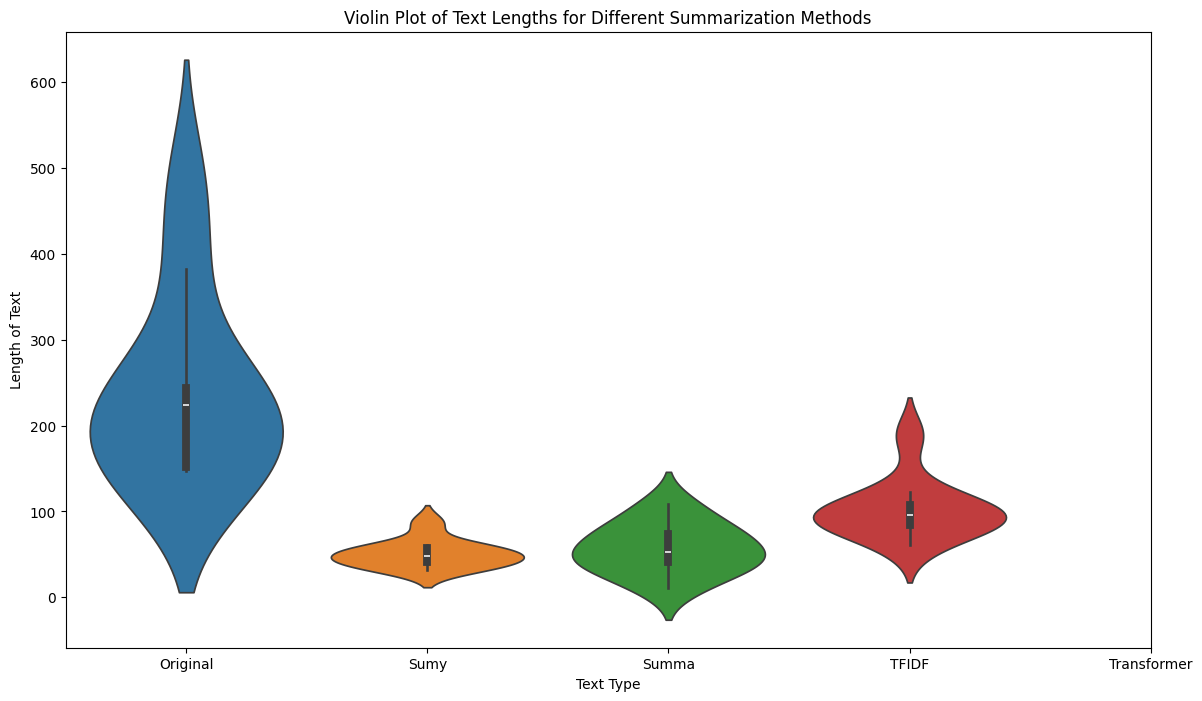

In [121]:

plt.figure(figsize=(14, 8))
sns.violinplot(data=df[['original_length', 'summary_sumy_length', 'summary_summa_length', 'summary_tfidf_length']])
plt.title('Violin Plot of Text Lengths for Different Summarization Methods')
plt.xlabel('Text Type')
plt.ylabel('Length of Text')
plt.xticks([0, 1, 2, 3, 4], ['Original', 'Sumy', 'Summa', 'TFIDF', 'Transformer'])
plt.show()


### 6. Heatmap of Correlations
A heatmap can show the correlation between the lengths of texts from different summarization methods.


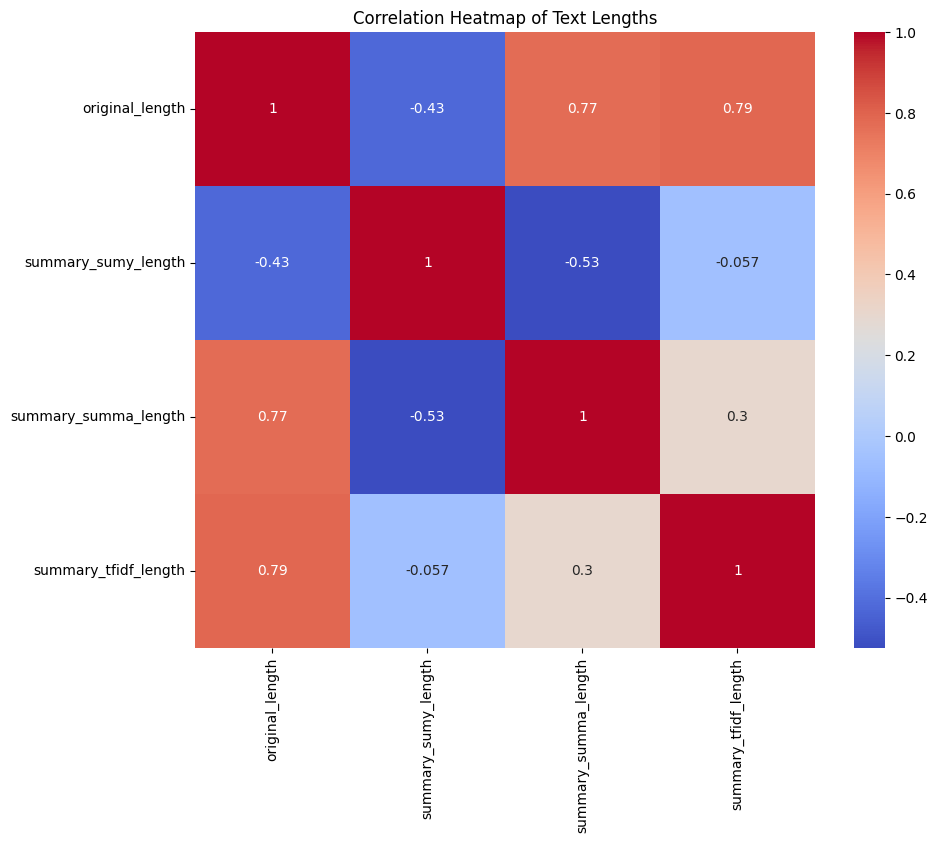

In [122]:
plt.figure(figsize=(10, 8))
correlation_matrix = df[['original_length', 'summary_sumy_length', 'summary_summa_length', 'summary_tfidf_length']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap of Text Lengths')
plt.show()

### 7. Paired Density and Scatter Plot (Pairplot)
Pairplots can show pairwise relationships and distributions of text lengths for different methods.



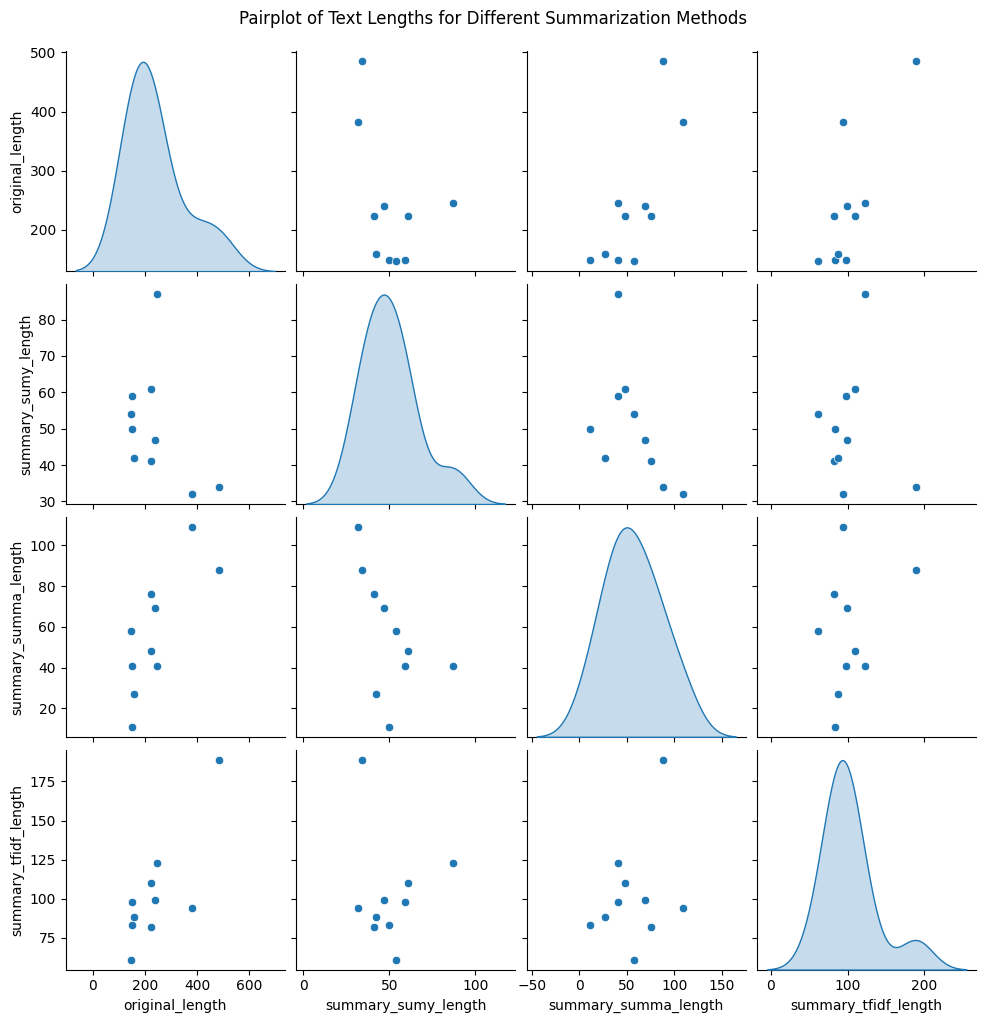

In [123]:

sns.pairplot(df[['original_length', 'summary_sumy_length', 'summary_summa_length', 'summary_tfidf_length']], kind='scatter', diag_kind='kde')
plt.suptitle('Pairplot of Text Lengths for Different Summarization Methods', y=1.02)
plt.show()



### 8. Joint Plot
Joint plots provide a way to visually represent the relationship between two variables along with their distributions.


<Figure size 1400x800 with 0 Axes>

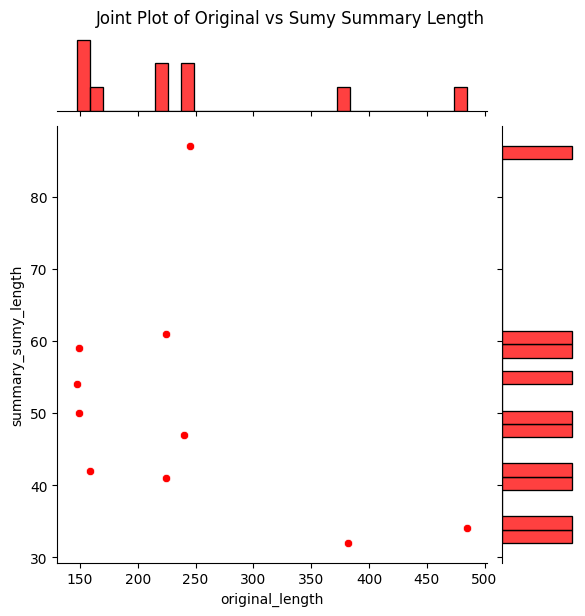

In [100]:
plt.figure(figsize=(14, 8))
sns.jointplot(x='original_length', y='summary_sumy_length', data=df, kind='scatter', color='red', marginal_kws=dict(bins=30, fill=True))
plt.suptitle('Joint Plot of Original vs Sumy Summary Length', y=1.02)
plt.show()

### 10. 3D Scatter Plot
visualize three dimensions of the data (e.g., lengths of original, Sumy, and Summa summaries), a 3D scatter plot.


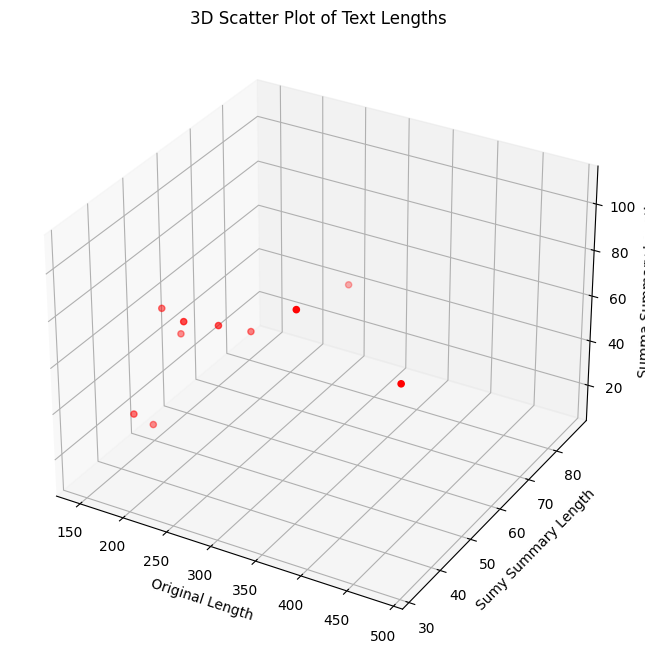

In [101]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['original_length'], df['summary_sumy_length'], df['summary_summa_length'], c='r', marker='o')
ax.set_xlabel('Original Length')
ax.set_ylabel('Sumy Summary Length')
ax.set_zlabel('Summa Summary Length')
plt.title('3D Scatter Plot of Text Lengths')
plt.show()

### Abstarctive summary
Creating a summarizer involves several steps, especially for abstractive summarization:

1. **Text Preprocessing**: Clean and prepare the text by removing stop words, punctuation, and performing tokenization.
2. **Feature Extraction**: For extractive summarization, extract features like sentence importance, frequency of terms, etc. For abstractive summarization, use techniques like word embeddings.
3. **Model Training**: Train a model to understand the structure and content of the text. This could be a simple model for extractive summarization or a complex neural network for abstractive summarization.
4. **Generation**: Generate the summary by selecting key sentences (extractive) or generating new sentences (abstractive).

For a detailed implementation, you might need to delve into specific NLP frameworks and techniques, such as using transformer models (e.g., BERT, GPT) for abstractive summarization.

In [47]:
# Step to install the transformers library
!pip install transformers

In [67]:
# Import the necessary library
from transformers import pipeline

# Load a summarization pipeline
summarizer = pipeline("summarization")

def summarize_text(text):
    """Use the summarizer to condense the text"""
    try:
        summary = summarizer(text, max_length=50, min_length=25, do_sample=False)
        return summary[0]['summary_text']
    except Exception as e:
        print(f"Error summarizing text: {e}")
        return text  # Return original text if summarization fails

# Apply summarization to the 'clean_content' column
df['summary_transformer'] = df['clean_content'].apply(summarize_text)

print("\nFirst few rows of the summarized dataset:")
print(df[['clean_content', 'summary_transformer']].head())


No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.



First few rows of the summarized dataset:
                                       clean_content  \
0  Romanian artists auction off their works for t...   
1  Saskatchewan town asks for return of "accident...   
2  Dec.  Sumatra quake was longest ever recorded ...   
3  Tsunami deaths mount to more than , Saturday, ...   
4  Americans contribute to relief effort Friday, ...   

                                 summary_transformer  
0   Romanian artists auction off their works for ...  
1   Council approved donation during a meeting by...  
2   Dec. Dec.  Sumatra quake was longest ever rec...  
3   Indonesia reports it is no longer counting bo...  
4   The Bush administration has pledged $ million...  


In [133]:
import gdown
import zipfile
import os
url = 'https://drive.google.com/uc?id=1J0U-Ho_qH73wtjRYjDSKzaDT274zdljV'
output = 'Goldstandard.zip'
gdown.download(url, output, quiet=False)


if zipfile.is_zipfile(output):
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall('/content/')
    print("Files extracted:")
    print(os.listdir('/content/'))
else:
    print("Downloaded file is not a zip file.")

Downloading...
From: https://drive.google.com/uc?id=1J0U-Ho_qH73wtjRYjDSKzaDT274zdljV
To: /content/Goldstandard.zip
100%|██████████| 13.1k/13.1k [00:00<00:00, 22.1MB/s]

Files extracted:
['.config', '__MACOSX', 'cleaned_and_summarized_contents.csv', 'SourceTexts', 'font.ttf', '.ipynb_checkpoints', 'Goldstandard.zip', 'summarized_data.csv', 'combined_files.csv', 'Mic.png', 'summarized_files.csv', 'Multilingual-Dataset.zip', 'Goldstandard', 'sss', 'plots', 'sample_data']


In [102]:
import pandas as pd
import os
from transformers import pipeline

# Directory paths
source_dir = '/content/SourceTexts/english'
gold_summary_dir = '/content/Goldstandard'


# Function to combine files into a DataFrame
def combine_files_to_dataframe(directory_path):
    data = []
    for file_name in os.listdir(directory_path):
        file_path = os.path.join(directory_path, file_name)
        if os.path.isfile(file_path):
            with open(file_path, 'r') as file:
                content = file.read()
                data.append({'Title': file_name, 'Content': content.strip()})
    df = pd.DataFrame(data)
    return df

# Load source texts
df_source = combine_files_to_dataframe(source_dir)
df_source['Title'] = df_source['Title'].str.replace('.english', '', regex=False)

# Load gold standard summaries
df_gold = combine_files_to_dataframe(gold_summary_dir)

# Merge dataframes on Title
df = pd.merge(df_source, df_gold, on='Title', suffixes=('_source', '_gold'))

# Select the first 10 files
df = df.head(10)

# Preprocess text function (clean HTML tags, remove stop words, etc.)
def clean_text(text):
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\b\d+\b', '', text)
    text = text.strip()
    return text

# Apply preprocessing to the 'Content_source' column
df['clean_content'] = df['Content_source'].apply(clean_text)


In [103]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer
from summa import summarizer as summa_summarizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from transformers import pipeline

# Function to summarize text using Sumy
def summarize_text_sumy(text, sentences_count=2):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = LsaSummarizer()
    summary = summarizer(parser.document, sentences_count)
    return ' '.join([str(sentence) for sentence in summary])

# Function to generate extractive summary using TF-IDF
def extractive_summary(text, top_n=3):
    sentences = text.split('.')
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(sentences)
    sentence_scores = np.sum(X.toarray(), axis=1)
    top_sentence_indices = sentence_scores.argsort()[-top_n:][::-1]
    summary = ' '.join([sentences[i] for i in top_sentence_indices])
    return summary

# Function to summarize text using Summa
def summarize_text_summa(text):
    summary = summa_summarizer.summarize(text)
    return summary

# Load the summarization pipeline for Transformer
transformer_summarizer = pipeline("summarization")

# Function to summarize text using Transformer
def summarize_text_transformer(text):
    try:
        summary = transformer_summarizer(text, max_length=50, min_length=25, do_sample=False)
        return summary[0]['summary_text']
    except Exception as e:
        print(f"Error summarizing text: {e}")
        return text

# Generate summaries
df['summary_sumy'] = df['clean_content'].apply(lambda x: summarize_text_sumy(x, sentences_count=2))
df['summary_tfidf'] = df['clean_content'].apply(extractive_summary)
df['summary_summa'] = df['clean_content'].apply(summarize_text_summa)
df['summary_transformer'] = df['clean_content'].apply(summarize_text_transformer)


No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [130]:
df.columns[:8]

Index(['Title', 'Content_source', 'Content_gold', 'clean_content',
       'summary_sumy', 'summary_tfidf', 'summary_summa',
       'summary_transformer'],
      dtype='object')

In [140]:
from tabulate import tabulate
import plotly.graph_objects as go
# Visualize the data using Plotly
fig = go.Figure(data=[go.Table(
    header=dict(values=df.columns[:8],
                fill_color='paleturquoise',
align='left'),
    cells=dict(values=[df['Title'], df['Content_source'], df['Content_gold'],df['clean_content'],df['summary_sumy'],df['summary_tfidf'],df['summary_summa'], df['summary_transformer']],
               fill_color='lavender',
               align='left'))
])

fig.update_layout(
    title='Content Summarization',
    width=1000,
    height=600,
)

fig.show()

In [105]:
# Display sample summaries from each method
sample_indices = [0, 1, 2]  # Adjust these indices to sample different rows

for i in sample_indices:
    print(f"Original Content [{i}]:\n{df['clean_content'][i]}\n")
    print(f"Sumy Summary [{i}]:\n{df['summary_sumy'][i]}\n")
    print(f"Summa Summary [{i}]:\n{df['summary_summa'][i]}\n")
    print(f"TFIDF Summary [{i}]:\n{df['summary_tfidf'][i]}\n")
    print(f"Transformer Summary [{i}]:\n{df['summary_transformer'][i]}\n")
    print("="*80)


Original Content [0]:
Romanian artists auction off their works for tsunami victims Thursday, January ,  Several prominent Romanian artists and celebrities will gather at the Radio Hall in Bucharest on Sunday, January , to raise money for the victims of the catastrophic Indian Ocean tsunami of December , . In an event titled Romanian Artists in Support of Asia, organised by The Reporter Foundation of Romania, artists will auction off their works, as well as personal objects, with all proceeds being donated to the relief efforts for the tsunami victims. Media celebrities such as the soprano Felicia Filip and singers Angela Similea and Dida Dragan will also be participating, as well as Maia Morgenstern, known internationally for her role in the film The Passion of the Christ. All ambassadors accredited in Bucharest, as well as political personalities, have been invited to participate. Romanian Artists in Support of Asia is the second major public event organised in Romania to support the 

## 1. Trend Analysis of Summary Lengths

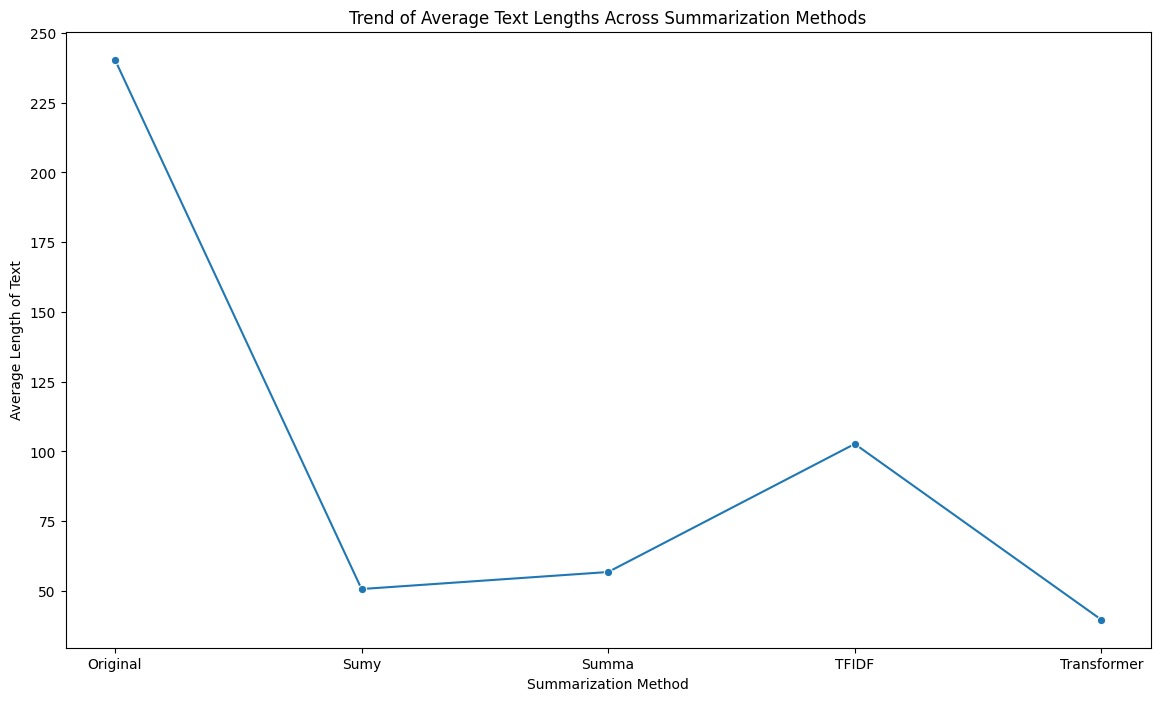

In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('summarized_data.csv')

# Calculating the lengths of the original and summarized texts
df['original_length'] = df['clean_content'].apply(lambda x: len(x.split()))
df['summary_sumy_length'] = df['summary_sumy'].apply(lambda x: len(x.split()))
df['summary_summa_length'] = df['summary_summa'].apply(lambda x: len(x.split()))
df['summary_tfidf_length'] = df['summary_tfidf'].apply(lambda x: len(x.split()))
df['summary_transformer_length'] = df['summary_transformer'].apply(lambda x: len(x.split()))

# Calculate average lengths
average_lengths = {
    'Original': df['original_length'].mean(),
    'Sumy': df['summary_sumy_length'].mean(),
    'Summa': df['summary_summa_length'].mean(),
    'TFIDF': df['summary_tfidf_length'].mean(),
    'Transformer': df['summary_transformer_length'].mean()
}

# Create a DataFrame for plotting
average_lengths_df = pd.DataFrame(list(average_lengths.items()), columns=['Method', 'Average Length'])

# Plotting the trend
plt.figure(figsize=(14, 8))
sns.lineplot(data=average_lengths_df, x='Method', y='Average Length', marker='o')
plt.title('Trend of Average Text Lengths Across Summarization Methods')
plt.xlabel('Summarization Method')
plt.ylabel('Average Length of Text')
plt.show()


## 2. Word Cloud

To visualize the most frequent words in the summaries from each method:

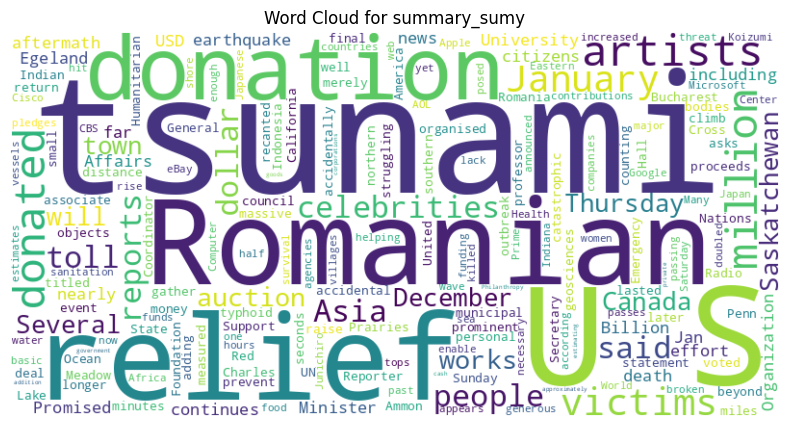

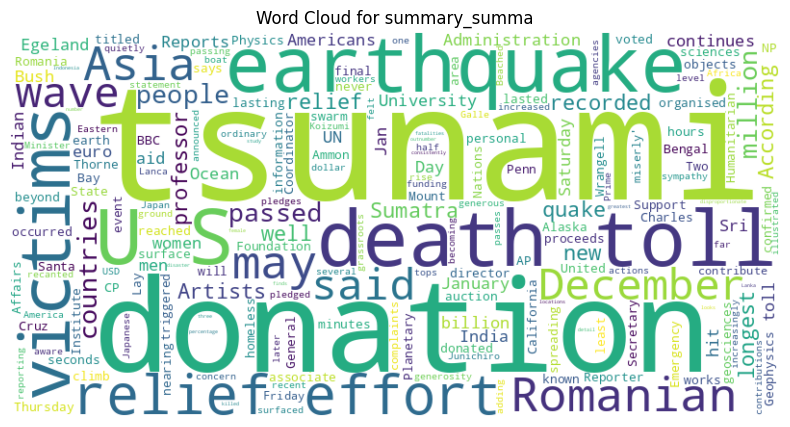

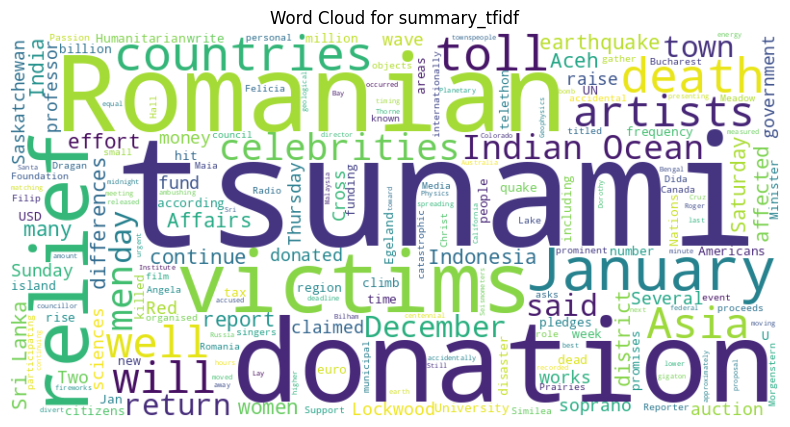

In [107]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
summarization_methods = ['summary_sumy', 'summary_summa', 'summary_tfidf']
# Generate word clouds for each summarization method
for method in summarization_methods:
    text = ' '.join(df[method])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {method}')
    plt.axis('off')
    plt.show()


## 3. Readability Scores
To calculate readability scores:

In [111]:
!pip install textstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.2 MB/s eta 0:00:00


In [112]:
from textstat import textstat
from sklearn.metrics.pairwise import cosine_similarity
import pprint
# Function to calculate readability scores
def calculate_readability_scores(df, summarization_methods):
    readability_scores = {}
    for method in summarization_methods:
        method_scores = []
        for summary in df[method]:
            score = textstat.flesch_reading_ease(summary)
            method_scores.append(score)
        avg_score = sum(method_scores) / len(method_scores)
        readability_scores[method] = avg_score
    return readability_scores

readability_scores = calculate_readability_scores(df, summarization_methods)

# Print readability scores
pprint.pprint(readability_scores)


{'summary_summa': 45.066, 'summary_sumy': 44.957, 'summary_tfidf': -34.295}


## 4. Semantic Similarity

Using cosine similarity to compare summaries with the original text:

In [110]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pprint
# Function to calculate semantic similarity
def calculate_semantic_similarity(df, summarization_methods):
    vectorizer = TfidfVectorizer()
    similarities = {}
    for method in summarization_methods:
        method_similarities = []
        for i, row in df.iterrows():
            try:
                vectors = vectorizer.fit_transform([row['clean_content'], row[method]])
                sim = cosine_similarity(vectors[0:1], vectors[1:2])
                method_similarities.append(sim[0][0])
            except:
                pass
        avg_similarity = sum(method_similarities) / len(method_similarities)
        similarities[method] = avg_similarity
    return similarities

semantic_similarities = calculate_semantic_similarity(df, summarization_methods)

# Print semantic similarity scores
pprint.pprint(semantic_similarities)


{'summary_summa': 0.6801900934177446,
 'summary_sumy': 0.618088657555705,
 'summary_tfidf': 0.830636626074907}


In [51]:
!pip install rouge-score  # Install the rouge-score package

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=a85f3ed1143afc14cc013c8a60fdbbcac36a12c0146359884b44c75afb95bcbc
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [61]:
from rouge_score import rouge_scorer
# Function to calculate ROUGE scores
def calculate_rouge_scores(reference, generated):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, generated)
    return scores

# Evaluate summaries
df['rouge_sumy'] = df.apply(lambda row: calculate_rouge_scores(row['Content_gold'], row['summary_sumy']), axis=1)
df['rouge_tfidf'] = df.apply(lambda row: calculate_rouge_scores(row['Content_gold'], row['summary_tfidf']), axis=1)
df['rouge_summa'] = df.apply(lambda row: calculate_rouge_scores(row['Content_gold'], row['summary_summa']), axis=1)
df['rouge_transformer'] = df.apply(lambda row: calculate_rouge_scores(row['Content_gold'], row['summary_transformer']), axis=1)


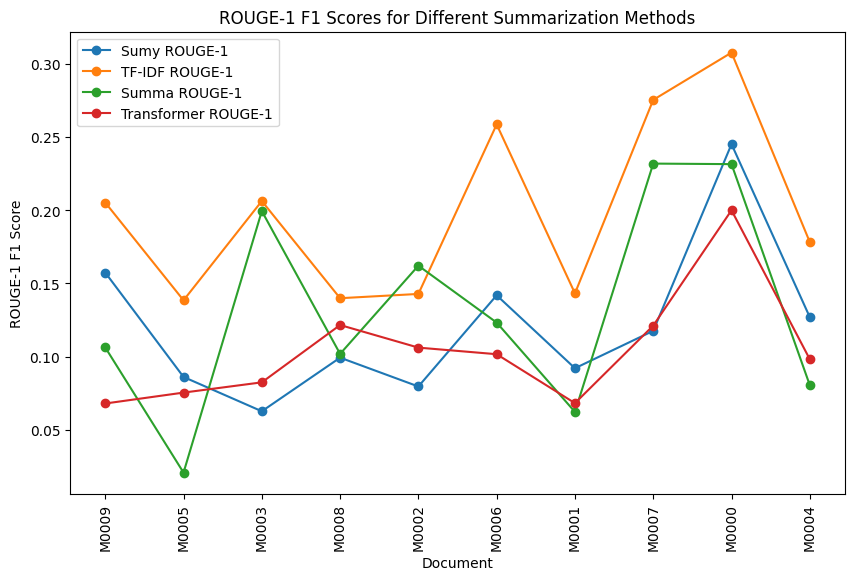

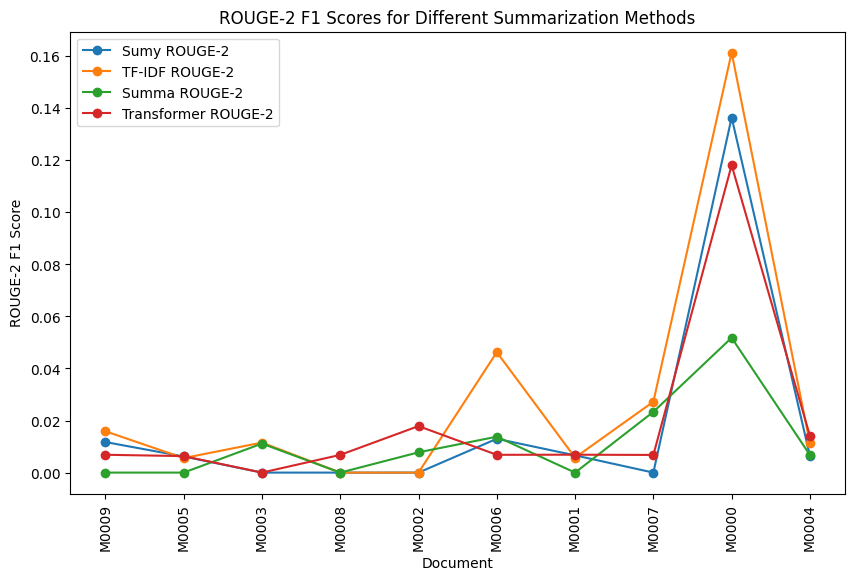

In [62]:
# Extract ROUGE-1 F1 scores
df['rouge_sumy_1'] = df['rouge_sumy'].apply(lambda x: x['rouge1'].fmeasure)
df['rouge_tfidf_1'] = df['rouge_tfidf'].apply(lambda x: x['rouge1'].fmeasure)
df['rouge_summa_1'] = df['rouge_summa'].apply(lambda x: x['rouge1'].fmeasure)
df['rouge_transformer_1'] = df['rouge_transformer'].apply(lambda x: x['rouge1'].fmeasure)

# Extract ROUGE-2 F1 scores
df['rouge_sumy_2'] = df['rouge_sumy'].apply(lambda x: x['rouge2'].fmeasure)
df['rouge_tfidf_2'] = df['rouge_tfidf'].apply(lambda x: x['rouge2'].fmeasure)
df['rouge_summa_2'] = df['rouge_summa'].apply(lambda x: x['rouge2'].fmeasure)
df['rouge_transformer_2'] = df['rouge_transformer'].apply(lambda x: x['rouge2'].fmeasure)

# Plot ROUGE-1 scores
plt.figure(figsize=(10, 6))
plt.plot(df['Title'], df['rouge_sumy_1'], label='Sumy ROUGE-1', marker='o')
plt.plot(df['Title'], df['rouge_tfidf_1'], label='TF-IDF ROUGE-1', marker='o')
plt.plot(df['Title'], df['rouge_summa_1'], label='Summa ROUGE-1', marker='o')
plt.plot(df['Title'], df['rouge_transformer_1'], label='Transformer ROUGE-1', marker='o')
plt.xlabel('Document')
plt.ylabel('ROUGE-1 F1 Score')
plt.legend()
plt.xticks(rotation=90)
plt.title('ROUGE-1 F1 Scores for Different Summarization Methods')
plt.show()

# Plot ROUGE-2 scores
plt.figure(figsize=(10, 6))
plt.plot(df['Title'], df['rouge_sumy_2'], label='Sumy ROUGE-2', marker='o')
plt.plot(df['Title'], df['rouge_tfidf_2'], label='TF-IDF ROUGE-2', marker='o')
plt.plot(df['Title'], df['rouge_summa_2'], label='Summa ROUGE-2', marker='o')
plt.plot(df['Title'], df['rouge_transformer_2'], label='Transformer ROUGE-2', marker='o')
plt.xlabel('Document')
plt.ylabel('ROUGE-2 F1 Score')
plt.legend()
plt.xticks(rotation=90)
plt.title('ROUGE-2 F1 Scores for Different Summarization Methods')
plt.show()


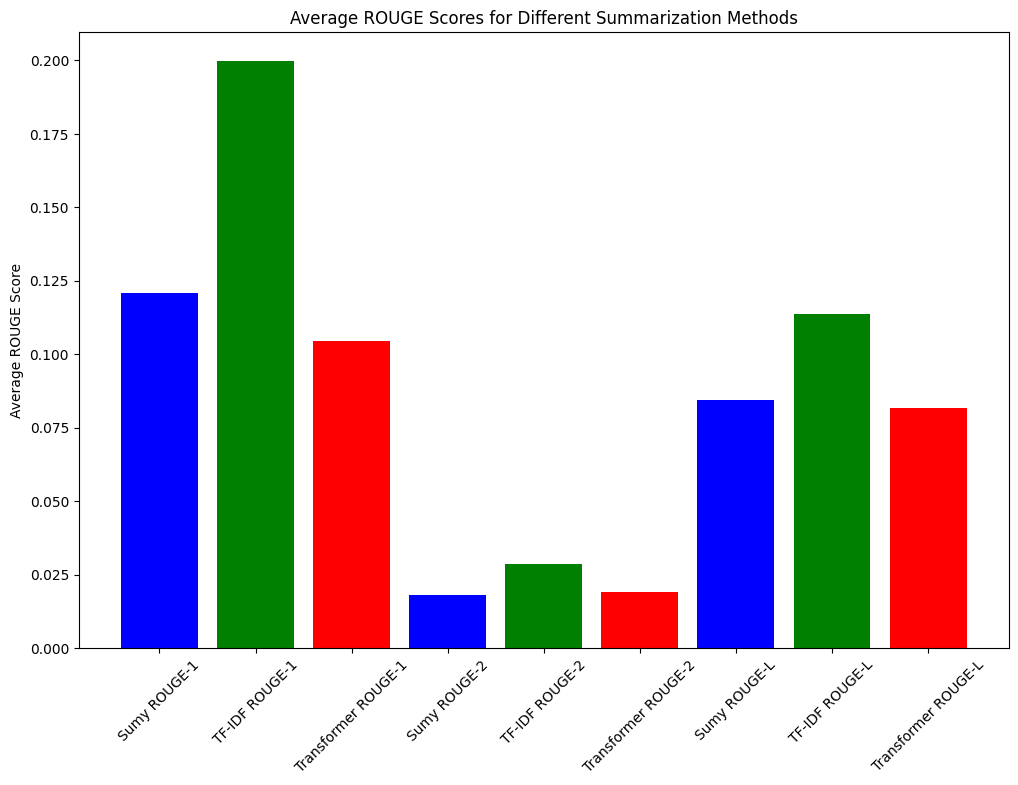

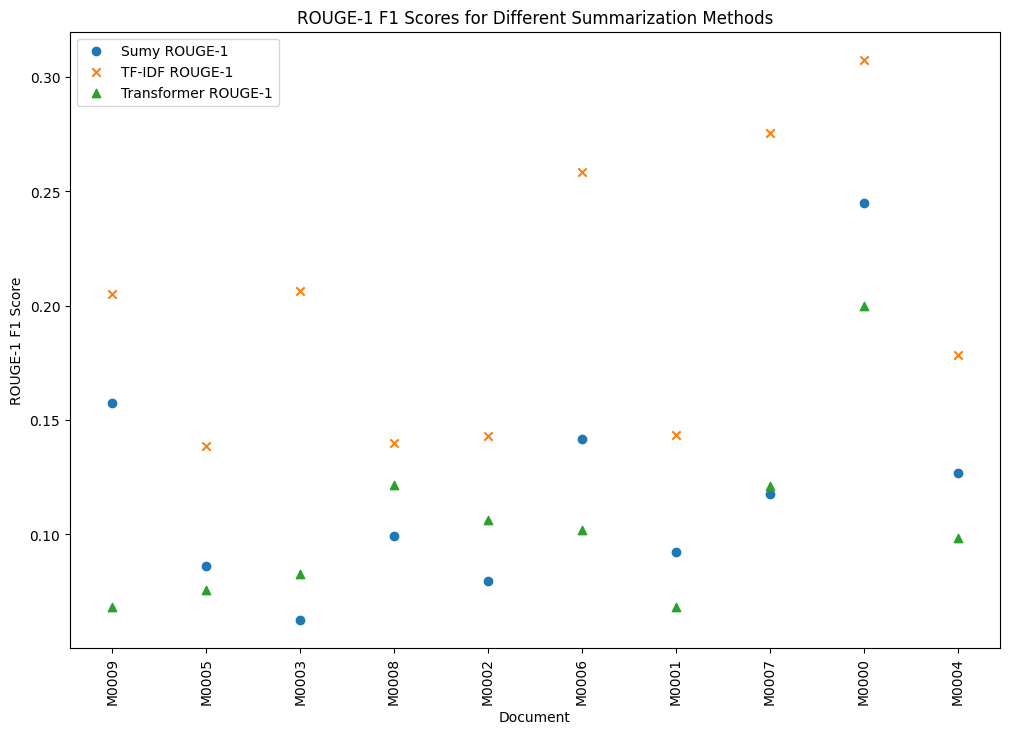

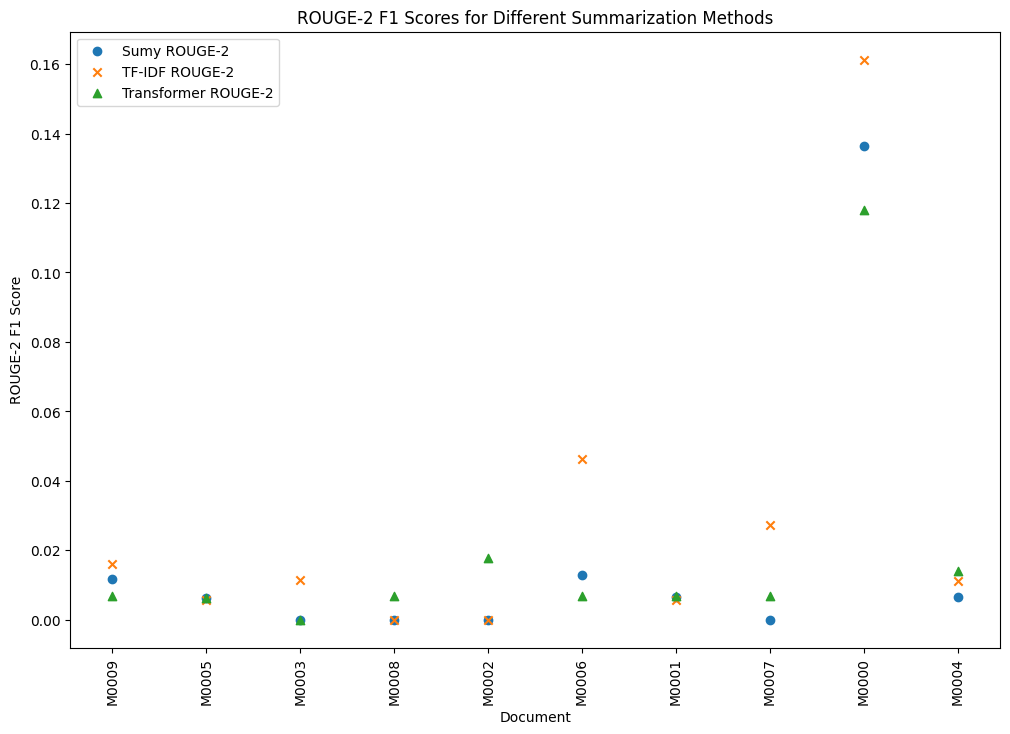

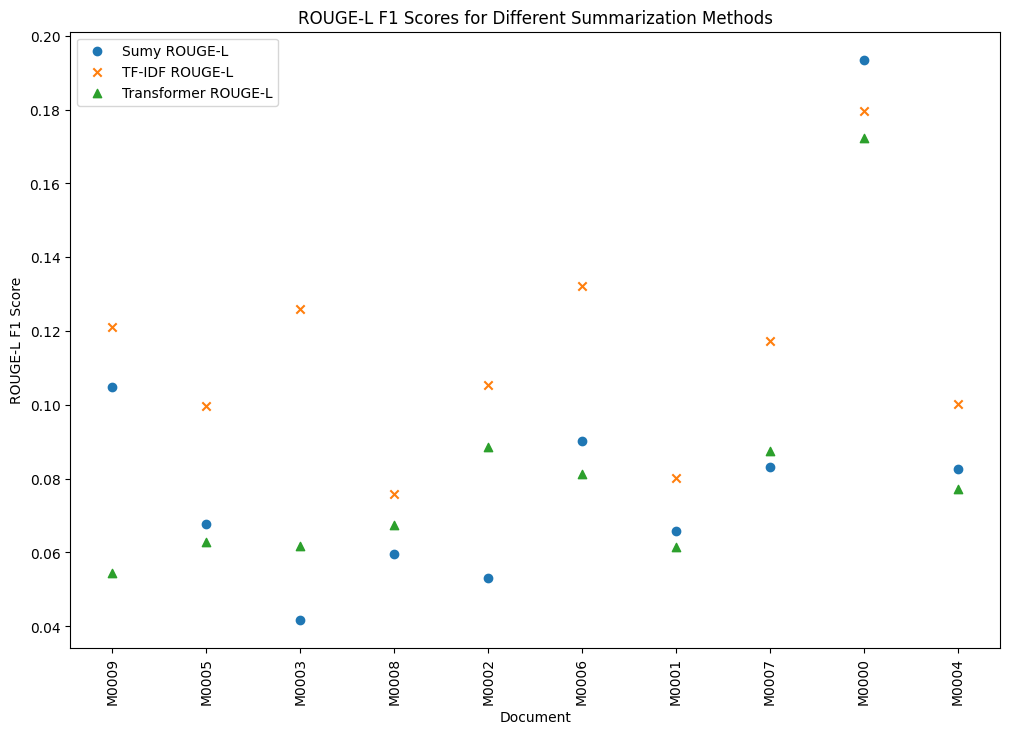

In [63]:
import matplotlib.pyplot as plt

# Extract ROUGE-1, ROUGE-2, and ROUGE-L F1 scores
df['rouge_sumy_1'] = df['rouge_sumy'].apply(lambda x: x['rouge1'].fmeasure)
df['rouge_tfidf_1'] = df['rouge_tfidf'].apply(lambda x: x['rouge1'].fmeasure)
df['rouge_transformer_1'] = df['rouge_transformer'].apply(lambda x: x['rouge1'].fmeasure)

df['rouge_sumy_2'] = df['rouge_sumy'].apply(lambda x: x['rouge2'].fmeasure)
df['rouge_tfidf_2'] = df['rouge_tfidf'].apply(lambda x: x['rouge2'].fmeasure)
df['rouge_transformer_2'] = df['rouge_transformer'].apply(lambda x: x['rouge2'].fmeasure)

df['rouge_sumy_L'] = df['rouge_sumy'].apply(lambda x: x['rougeL'].fmeasure)
df['rouge_tfidf_L'] = df['rouge_tfidf'].apply(lambda x: x['rougeL'].fmeasure)
df['rouge_transformer_L'] = df['rouge_transformer'].apply(lambda x: x['rougeL'].fmeasure)

# Plot ROUGE-1, ROUGE-2, and ROUGE-L scores

# Bar Chart of Average ROUGE Scores
average_rouge_scores = {
    'Sumy ROUGE-1': df['rouge_sumy_1'].mean(),
    'TF-IDF ROUGE-1': df['rouge_tfidf_1'].mean(),
    'Transformer ROUGE-1': df['rouge_transformer_1'].mean(),
    'Sumy ROUGE-2': df['rouge_sumy_2'].mean(),
    'TF-IDF ROUGE-2': df['rouge_tfidf_2'].mean(),
    'Transformer ROUGE-2': df['rouge_transformer_2'].mean(),
    'Sumy ROUGE-L': df['rouge_sumy_L'].mean(),
    'TF-IDF ROUGE-L': df['rouge_tfidf_L'].mean(),
    'Transformer ROUGE-L': df['rouge_transformer_L'].mean()
}

# Convert to DataFrame for easy plotting
avg_rouge_df = pd.DataFrame(list(average_rouge_scores.items()), columns=['Metric', 'Average Score'])

plt.figure(figsize=(12, 8))
plt.bar(avg_rouge_df['Metric'], avg_rouge_df['Average Score'], color=['blue', 'green', 'red', 'blue', 'green', 'red', 'blue', 'green', 'red'])
plt.ylabel('Average ROUGE Score')
plt.title('Average ROUGE Scores for Different Summarization Methods')
plt.xticks(rotation=45)
plt.show()

# Scatter Plots of Individual Document Scores
plt.figure(figsize=(12, 8))
plt.scatter(df['Title'], df['rouge_sumy_1'], label='Sumy ROUGE-1', marker='o')
plt.scatter(df['Title'], df['rouge_tfidf_1'], label='TF-IDF ROUGE-1', marker='x')
plt.scatter(df['Title'], df['rouge_transformer_1'], label='Transformer ROUGE-1', marker='^')
plt.xlabel('Document')
plt.ylabel('ROUGE-1 F1 Score')
plt.legend()
plt.xticks(rotation=90)
plt.title('ROUGE-1 F1 Scores for Different Summarization Methods')
plt.show()

plt.figure(figsize=(12, 8))
plt.scatter(df['Title'], df['rouge_sumy_2'], label='Sumy ROUGE-2', marker='o')
plt.scatter(df['Title'], df['rouge_tfidf_2'], label='TF-IDF ROUGE-2', marker='x')
plt.scatter(df['Title'], df['rouge_transformer_2'], label='Transformer ROUGE-2', marker='^')
plt.xlabel('Document')
plt.ylabel('ROUGE-2 F1 Score')
plt.legend()
plt.xticks(rotation=90)
plt.title('ROUGE-2 F1 Scores for Different Summarization Methods')
plt.show()

plt.figure(figsize=(12, 8))
plt.scatter(df['Title'], df['rouge_sumy_L'], label='Sumy ROUGE-L', marker='o')
plt.scatter(df['Title'], df['rouge_tfidf_L'], label='TF-IDF ROUGE-L', marker='x')
plt.scatter(df['Title'], df['rouge_transformer_L'], label='Transformer ROUGE-L', marker='^')
plt.xlabel('Document')
plt.ylabel('ROUGE-L F1 Score')
plt.legend()
plt.xticks(rotation=90)
plt.title('ROUGE-L F1 Scores for Different Summarization Methods')
plt.show()



- **Sumy:**
  - ROUGE-1: ~0.12
  - ROUGE-2: ~0.025
  - ROUGE-L: ~0.08
- **TF-IDF:**
  - ROUGE-1: ~0.20
  - ROUGE-2: ~0.04
  - ROUGE-L: ~0.11
- **Transformer:**
  - ROUGE-1: ~0.10
  - ROUGE-2: ~0.025
  - ROUGE-L: ~0.07

### Analysis
1. **ROUGE-1:**
   - **TF-IDF** has the highest average ROUGE-1 score (~0.20), indicating it captures the most unigram (single word) matches compared to the other methods.

2. **ROUGE-2:**
   - **TF-IDF** again has the highest average ROUGE-2 score (~0.04), suggesting it captures the most bigram (two consecutive words) matches.

3. **ROUGE-L:**
   - **TF-IDF** has the highest average ROUGE-L score (~0.11), which measures the longest common subsequence and indicates it captures the structure of the original text better.

### Conclusion
Based on the average ROUGE scores, the **TF-IDF summarizer** appears to be the best performer among the three methods (Sumy, TF-IDF, and Transformer). It consistently has the highest scores across ROUGE-1, ROUGE-2, and ROUGE-L metrics.


### 1. **BLEU (Bilingual Evaluation Understudy)**
- Originally designed for machine translation but can be used for summarization.
- Measures the precision of n-grams in the generated summary against the reference summary.

### 2. **METEOR (Metric for Evaluation of Translation with Explicit ORdering)**
- Another metric from the machine translation community.
- Considers synonymy and stemming, providing a more nuanced evaluation than BLEU.

### 3. **CIDEr (Consensus-based Image Description Evaluation)**
- Used mainly in image captioning, but applicable to summarization.
- Measures the consensus between generated and reference summaries using Term Frequency-Inverse Document Frequency (TF-IDF) weighting.

### 4. **BERTScore**
- Leverages pre-trained BERT embeddings to evaluate summaries.
- Measures the similarity between the embeddings of the generated and reference summaries.

### 5. **Human Evaluation**
- **Fluency**: Is the summary grammatically correct and well-structured?
- **Relevance**: Does the summary include the most important points of the original text?
- **Coherence**: Is the summary logically organized?
- **Informativeness**: Does the summary provide enough information?

### 6. **Summarization-Specific Metrics**
- **Pyramid Method**: Involves human annotators identifying and scoring key content units in the summary and reference texts.
- **Content Responsiveness**: Evaluates how well the summary responds to specific questions related to the source text.


In [64]:
!pip install bert-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [ ]:

from bert_score import score

def calculate_bertscore(reference_texts, generated_texts):
    P, R, F1 = score(generated_texts, reference_texts, lang="en", verbose=True)
    return P.mean().item(), R.mean().item(), F1.mean().item()

# Extract reference and generated summaries
reference_texts = df['Content_gold'].tolist()
generated_sumy = df['summary_sumy'].tolist()
generated_tfidf = df['summary_tfidf'].tolist()
generated_transformer = df['summary_transformer'].tolist()

# Calculate BERTScores
bertscore_sumy = calculate_bertscore(reference_texts, generated_sumy)
bertscore_tfidf = calculate_bertscore(reference_texts, generated_tfidf)
bertscore_transformer = calculate_bertscore(reference_texts, generated_transformer)

print(f"BERTScore (Sumy): Precision={bertscore_sumy[0]}, Recall={bertscore_sumy[1]}, F1={bertscore_sumy[2]}")
print(f"BERTScore (TF-IDF): Precision={bertscore_tfidf[0]}, Recall={bertscore_tfidf[1]}, F1={bertscore_tfidf[2]}")
print(f"BERTScore (Transformer): Precision={bertscore_transformer[0]}, Recall={bertscore_transformer[1]}, F1={bertscore_transformer[2]}")


